In [14]:
import torch  
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import struct
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
import os

"Using Cuda" if torch.cuda.is_available() else "Not using Cuda"

'Using Cuda'

In [15]:
train_images = './data/MNIST_ORG/t10k-images.idx3-ubyte'
train_labels =  './data/MNIST_ORG/t10k-labels.idx1-ubyte'
test_images = './data/MNIST_ORG/train-images.idx3-ubyte'
test_labels = './data/MNIST_ORG/train-labels.idx1-ubyte'

for path in [train_images, train_labels, test_images, test_labels]:
    if not os.path.isfile(path):
        assert False, f"Training data at {path} does not exist"

In [16]:
# parsed according to https://yann.lecun.com/exdb/mnist/ 
class DigitDataset(Dataset):
    def __init__(self, images_fp, labels_fp):
        self.x = self.read_images(images_fp)
        self.y = self.read_labels(labels_fp)
        self.y = F.one_hot(self.y, num_classes=10).float()
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    @staticmethod
    def read_images(filename):
        with open(filename, 'rb') as f:
            # read 4 i32 values in big endian
            magic_number, num_images, num_rows, num_cols = struct.unpack(">iiii", f.read(16))
            assert magic_number == 2051, f"Invalid magic number for images: {magic_number}"

            images = torch.frombuffer(f.read(), dtype=torch.uint8) 
            images = images.reshape(num_images, num_rows, num_cols).float() / 255.0  # Normalize to [0, 1]
            
        return images

    @staticmethod
    def read_labels(filename):
        with open(filename, 'rb') as f:
            magic_number, num_labels = struct.unpack(">ii", f.read(8))
            assert magic_number == 2049, f"Invalid magic number for labels: {magic_number}"

            # cast to long so we can use it one_hot encoding
            labels = torch.frombuffer(f.read(), dtype=torch.uint8).long()
        
        return labels

In [17]:
def plot_image(image, label = "Untitled"):
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

In [18]:
# Create datasets
train_dataset = DigitDataset(train_images, train_labels)

xs = train_dataset.read_images(train_images)
ys = train_dataset.read_labels(train_labels)
xs.shape

C:\Users\tim-s\AppData\Local\Temp\ipykernel_14824\49506426.py:21: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:1550.)
  images = torch.frombuffer(f.read(), dtype=torch.uint8)


torch.Size([10000, 28, 28])

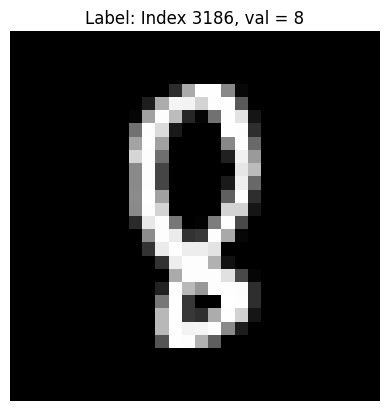

In [19]:

idx = torch.randint(0, xs.shape[0], (1,)).item()
plot_image(xs[idx], f"Index {idx}, val = {ys[idx].item()}")

### One Hot Encoder

Now though our labels are $1,2,3 \ldots ,8,9$ it important to stress that the magnitude or the value of these number do not matter. That is to say there is no sense of label $1$ being less than label $8$ they're just id's. So we want to encode them into different dimensions for one-ness, two-ness etc ... on different axis. We do this vai the one_hot encoder 

In [20]:
ys = F.one_hot(ys)
ys

tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

Now these images need to be vectors, so we'll stretch it out into a $\mathrm{rows} \times \mathrm{cols}=28 \times 28 = 784 \; \mathrm{px}$ pixel array.

In [21]:
xs = xs.reshape(xs.shape[0], -1)

So my batch size is $5$ and i have $n=1\times10^4$ images so the length should be $\dfrac{1\times10^4}{5}=2\times10^3$

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=5)
len(train_dataloader)

2000

### Defining the network

In [23]:
class MnistNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.M1 = nn.Linear(train_dataset.x.shape[1] * train_dataset.x.shape[2], 128)
        self.M2 = nn.Linear(128, 64)
        self.M3 = nn.Linear(64, 10)
        self.R = nn.ReLU()

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.R(self.M1(x))  
        x = self.R(self.M2(x))
        x = self.M3(x)
        return x.squeeze()

### Training

In [24]:
from typing import Type, Callable, Any

def train(
    net: Type[nn.Module],
    dl: DataLoader,
    loss_fn: Callable[[Any, Any], torch.float],
    num_epochs: int,
    lr: float = 0.001,
    use_adam: bool = False,
) -> tuple[Type[nn.Module], list[float]]:
    f = net()
    opt = Adam(f.parameters(), lr=lr) if use_adam else SGD(f.parameters(), lr=lr)
    losses = []
    for ep in range(num_epochs):
        N = len(dl)
        for i, (x,y) in enumerate(dl):
            opt.zero_grad()
            y_hat = f(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        print(f"Epoch {ep+1}/{num_epochs}, Loss: {loss.item()}")

    return f, losses

In [38]:
L = nn.CrossEntropyLoss()
f = MnistNeuralNet()

# right now it produces garbage, as you can see the expect on right and predicted on left
torch.dstack((ys, f(xs)))[0]

tensor([[[ 0.0000e+00, -4.2355e-02],
         [ 0.0000e+00,  1.8825e-02],
         [ 0.0000e+00,  1.5111e-01],
         [ 0.0000e+00, -8.5714e-02],
         [ 0.0000e+00,  6.9058e-04],
         [ 0.0000e+00, -7.0385e-02],
         [ 0.0000e+00,  7.0707e-02],
         [ 1.0000e+00,  1.0130e-01],
         [ 0.0000e+00,  1.9064e-01],
         [ 0.0000e+00,  3.7403e-02]],

        [[ 0.0000e+00, -3.6531e-02],
         [ 0.0000e+00, -2.1317e-02],
         [ 1.0000e+00,  1.2541e-01],
         [ 0.0000e+00, -1.4616e-01],
         [ 0.0000e+00, -2.1561e-02],
         [ 0.0000e+00,  3.4172e-02],
         [ 0.0000e+00,  1.1895e-01],
         [ 0.0000e+00,  8.9575e-02],
         [ 0.0000e+00,  1.9846e-01],
         [ 0.0000e+00,  1.6947e-02]]], grad_fn=<SliceBackward0>)

Epoch 1/20, Loss: 1.214494228363037
Epoch 2/20, Loss: 1.4567110156349372e-05
Epoch 3/20, Loss: 0.0005772903095930815
Epoch 4/20, Loss: 7.152556236178498e-08
Epoch 5/20, Loss: 7.533885309385369e-06
Epoch 6/20, Loss: 2.8610210733859276e-07
Epoch 7/20, Loss: 2.384185648907078e-08
Epoch 8/20, Loss: 0.00016017697635106742
Epoch 9/20, Loss: -0.0
Epoch 10/20, Loss: 0.003260382916778326
Epoch 11/20, Loss: -0.0
Epoch 12/20, Loss: 0.00011695779539877549
Epoch 13/20, Loss: -0.0
Epoch 14/20, Loss: -0.0
Epoch 15/20, Loss: 0.00226742890663445
Epoch 16/20, Loss: -0.0
Epoch 17/20, Loss: -0.0
Epoch 18/20, Loss: -0.0
Epoch 19/20, Loss: -0.0
Epoch 20/20, Loss: -0.0


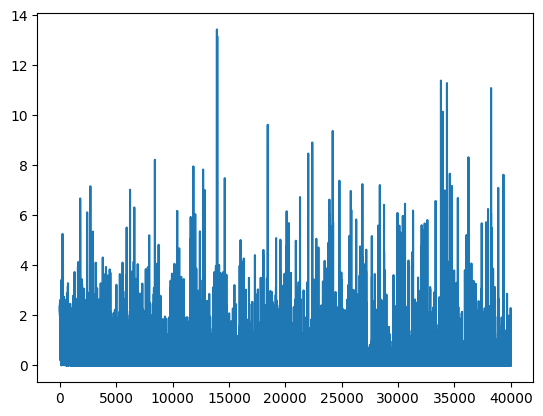

In [26]:
f, losses = train(MnistNeuralNet, train_dataloader, L, 20, lr=0.0075, use_adam=True)

plt.plot(losses)
plt.show()

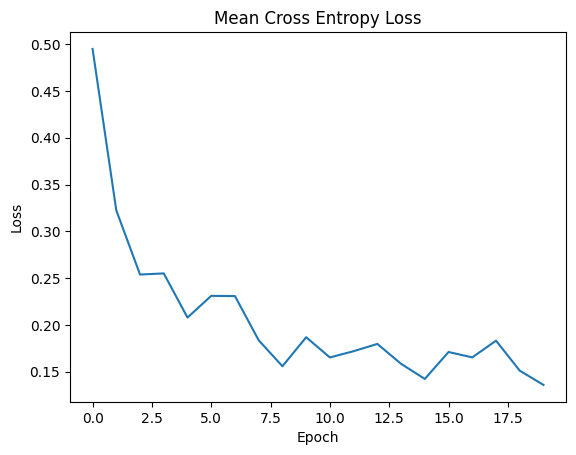

In [27]:
losses = torch.Tensor(losses)
losses = losses.reshape(20,-1) # losses per epoch
losses = losses.mean(axis=1)

plt.plot(losses)
plt.title("Mean Cross Entropy Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [28]:
torch.dstack((ys[65], f(xs)[65]))

tensor([[[   0.0000, -120.0993],
         [   0.0000, -111.3357],
         [   0.0000,  -51.1930],
         [   0.0000, -149.3087],
         [   1.0000,   30.2946],
         [   0.0000,  -87.4635],
         [   0.0000,  -50.6259],
         [   0.0000,  -65.1805],
         [   0.0000,  -40.3501],
         [   0.0000,  -27.3816]]], grad_fn=<CatBackward0>)

In [29]:
# now test on new data, so we can see if it has under or over-fitted  
test_data = DigitDataset(test_images, test_labels)
tx = test_data.x 
ty = test_data.y
ty_hat = f(tx.reshape(tx.shape[0], -1))

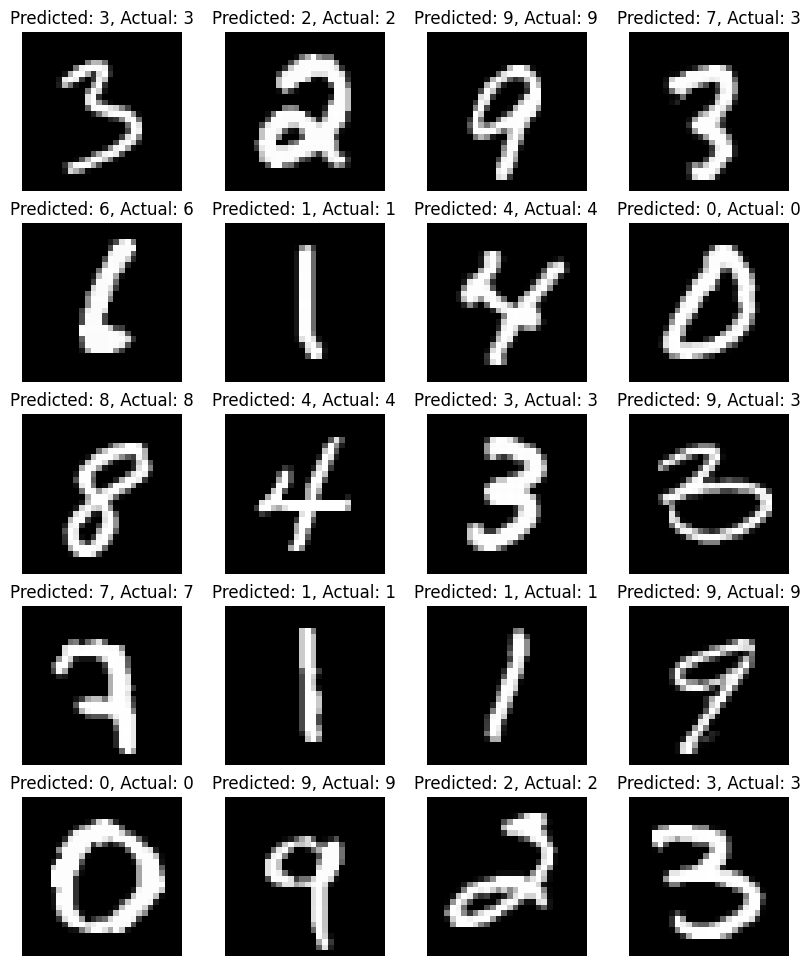

In [30]:
lenx, leny = 4, 5

fig, ax = plt.subplots(leny, lenx, figsize=(10,12))
random_idxs = torch.randint(0, tx.shape[0], (leny*lenx,))
for i,idx in enumerate(random_idxs):
    yi_hat = ty_hat[idx]
    yi = ty[idx]
    label = f"Predicted: {yi_hat.argmax().item()}, Actual: {yi.argmax().item()}"

    plt.subplot(leny,lenx,i+1)
    plt.imshow(tx[idx], cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.show()